In [170]:
%matplotlib inline
from matplotlib import pyplot as plt
import dataprob
import pandas as pd
import numpy as np

### Example model and data

Models should have the form:
```
def some_model(param1,param2,param3,...other_args,...other_kwargs):
    return observable
```

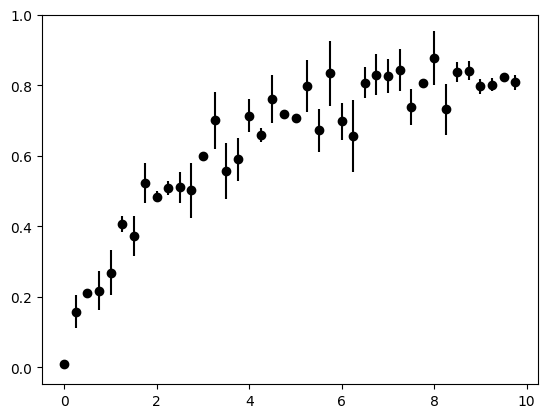

,X,Y,Y_stdev,residual,weighted_residual
0,0.00,0.010697,0.010697,0.010697,1.0
1,0.25,0.158333,0.047222,0.047222,1.0
2,0.50,0.209849,0.009849,0.009849,1.0
3,0.75,0.217865,0.054863,-0.054863,-1.0
4,1.00,0.268995,0.064339,-0.064339,-1.0


In [171]:
def binding_model(K,X=None):
    """
    Simple, saturating binding curve.

    K: association constant
    X: vector of X concentrations
    """

    return K*X/(1 + K*X)

df = pd.read_csv("binding-curves_noise-0.050.csv",index_col=0)

fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")
plt.show()

df.head()

### Wrap the binding model

### Construct the fitter and do the fit

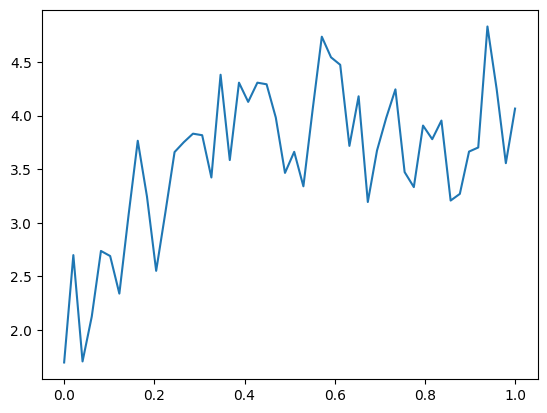

In [172]:
# def linear(m,b,x): 
#     return b + m*x

# N = 50
# stdev = 3
# slope = 5
# intercept = 2
# x = np.linspace(0,1,N)
# y_obs = linear(slope,intercept,x) + np.random.normal(0,stdev,N)
# y_stdev = stdev*np.ones(N,dtype=float)

# mw = dataprob.wrap_function(linear,fit_parameters=["m","b"])
# mw.x = x


def saturating_exponential(k,h,offset,x):
    return (1 - np.exp(-k*x))*h + offset

N = 50
stdev = 0.5
k = 5
h = 2
offset = 2
x = np.linspace(0,1,N)
y_obs = saturating_exponential(k=k,h=h,offset=offset,x=x) + np.random.normal(0,stdev,N)
y_stdev = stdev*np.ones(N,dtype=float)

mw = dataprob.wrap_function(saturating_exponential,fit_parameters=["k","h","offset"])
mw.x = x
mw.k.guess = 1
mw.h.guess = 1
mw.offset.guess = 0

plt.plot(x,y_obs)
f = dataprob.MLFitter()
f.model = mw
f.y_obs = y_obs
f.y_stdev = y_stdev


f.fit()


In [173]:
# # Wrap the binding model and set the 'X' parameter
# mw = dataprob.wrap_function(binding_model)
# mw.X = df.X
# #mw.K.prior = [0.5,10000]

# # Create a fitter and indicate the model is mw
# f = dataprob.MLFitter()
# f.model = mw
# f.guesses = [1]

# # Find parameters of binding_model that maximize the likelihood of the
# # seeing df.Y given df.X. 
# f.fit(y_obs=df.Y,y_stdev=df.Y_stdev)

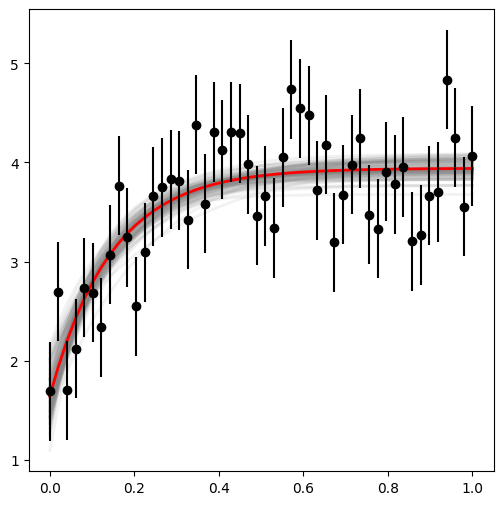

In [174]:
sample_df = f.get_sample_df()

fig, ax = plt.subplots(1,figsize=(6,6))
ax.errorbar(mw.x,
            sample_df.y_obs,
            yerr=sample_df.y_stdev,
            fmt="o",color="black",zorder=20)

draw_kwargs = {"alpha":0.1,
               "lw":2,
               "color":"gray"}
for k in sample_df.columns:
    if k.startswith("s"):
        ax.plot(mw.x,sample_df[k],'-',**draw_kwargs)

ax.plot(mw.x,sample_df["y_calc"],'-',color="red",lw=2,zorder=5)
plt.show()

a = f.fit_df


### Alternate way to construct fitter and do fit

In [180]:
class Yo:

    def __init__(self):

        self._df = pd.DataFrame({"x":["a","b","c"],"y":[1,2,3]})
        self._df.index = self._df.x
    
    def __getattr__(self,key):

        if key in self._df.index:
            return self._df.loc[key,:]
        else:
            super().__getattribute__(key)


        

0    1
1    2
2    3
Name: x, dtype: object

In [197]:
pd.DataFrame({"out":[1,2]})["out"])

0    1
1    2
Name: out, dtype: int64

In [ ]:
f = dataprob.MLFitter()
f.model = mw.model
f.guesses = [1]
f.y_obs = df.Y
f.fit()
print(f.success)
print(f.estimate)
f.fit_df

### Add weighted residuals

In [ ]:
f = dataprob.MLFitter()
f.fit(model=mw.model,y_obs=df.Y,y_stdev=df.Y_stdev)
print(f.success)
print(f.estimate)
f.fit_df

### Plotting

In [ ]:
# Plot the fit
fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")
#ax.plot(df.X,mw.model(),"-",color='red')
ax.plot(df.X,mw.model(f.estimate),"-",color='red')

### Corner plot

In [ ]:
f.corner_plot()

### You can add parameter bounds and names

In [ ]:
mw.bounds

In [ ]:
f = dataprob.MLFitter()
f.model = mw.model
f.guesses = [1.0]
f.y_obs = df.Y
f.y_stdev = df.Y_stdev
f.bounds = [[0],[np.inf]]
f.param_names = ["Kx"]
f.fit()
print(f.success)
print(f.estimate)
f.fit_df

### Bayesian fitter

In [ ]:
f = dataprob.BayesianFitter()
f.fit(model=mw.model,guesses=[1.0],y_obs=df.Y,y_stdev=df.Y_stdev)
print(f.success)
print(f.estimate)
f.fit_df


In [ ]:
fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")

# Plot 100 fits sampled from posterior
for i in range(0,len(f.samples),90):
    ax.plot(df.X,mw.model(f.samples[i,:]),"-",color='red',alpha=0.1)